In [1]:
from astropy.table import QTable
from astropy.io import fits

import sys

sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from Pipe3D_rotation_curve import extract_data
from Pipe3D_rotation_curve_functions import build_mask

sys.path.insert(2, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/')
from mapSmoothness_functions import how_smooth

import matplotlib.pyplot as plt

## Galaxy data

In [5]:
galaxies = QTable.read('../spirals/Pipe3D-master_file_vflag_10.txt', format='ascii.ecsv')

galaxies['smoothness_score'] = -1.

## Calculate smoothness scores

In [6]:
for i in range(len(galaxies)):
    
    ############################################################################
    # Build galaxy file name
    #---------------------------------------------------------------------------
    plate = galaxies['MaNGA_plate'][i]
    IFU = galaxies['MaNGA_fiberID'][i]
    
    galaxy_fits_filename = '../data/MaNGA/MaNGA_DR15/pipe3d/' + str(plate) + '/manga-' + str(plate) + '-' + str(IFU) + '.Pipe3D.cube.fits.gz'
    ############################################################################


    ############################################################################
    # Read in data
    #---------------------------------------------------------------------------
    _,_, Ha_vel, Ha_vel_error, v_band, v_band_err, sMass_density,_,_ = extract_data( galaxy_fits_filename)


    data_mask = build_mask( Ha_vel_error, v_band, v_band_err, sMass_density)
    ############################################################################


    ############################################################################
    # Calculate degree of smoothness of velocity map
    #---------------------------------------------------------------------------
    smoothness_score = how_smooth( Ha_vel, data_mask)

    galaxies['smoothness_score'][i] = smoothness_score
    ############################################################################
    
galaxies.write('../spirals/Pipe3D-master_file_vflag_10_smooth.txt', format='ascii.ecsv')

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/mapSmoothness_functions.py:93: RuntimeWarning: invalid value encountered in true_divide
  return score/num_unmasked_spaxels


In [7]:
galaxies = QTable.read('../spirals/Pipe3D-master_file_vflag_10_smooth.txt', format='ascii.ecsv')

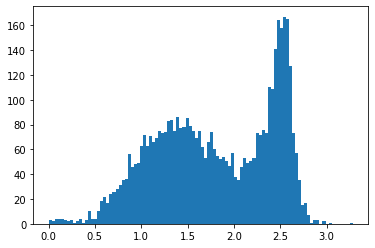

In [8]:
%matplotlib inline

plt.figure()

plt.hist(galaxies['smoothness_score'], bins=100);